In [1]:
!pip install pathway bokeh --quiet
!pip install bokeh --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.6/777.6 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.6/244.6 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.4/318.4 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.8/985.8 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd

data = pd.read_csv("dataset.csv")
data.head()


,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00


In [3]:
data.columns = data.columns.str.lower()
data['timestamp'] = pd.to_datetime(
    data['lastupdateddate'] + ' ' + data['lastupdatedtime'],
    format="%d-%m-%Y %H:%M:%S",
    errors='coerce'
)
data = data.sort_values('timestamp').reset_index(drop=True)
data['t'] = data['timestamp']
data['day'] = data['t'].dt.normalize()


Model - 1 - *Baseline Linear Model*

In [4]:
def BaselineModelPrice(occupancy, capacity, alpha=5, base_price=10):
    ratio = occupancy / capacity
    if ratio < 1:
        return round(base_price + alpha * ratio, 2)
    else:
        return round(base_price + alpha, 2)
data['base_price'] = 10
data['new_price'] = data.apply(
    lambda row: BaselineModelPrice(
        row['occupancy'],
        row['capacity'],
        alpha=5,
        base_price=row['base_price']
    ),
    axis=1
)
display(data[['occupancy', 'capacity', 'base_price', 'new_price']].head())

,occupancy,capacity,base_price,new_price
0,61,577,10,10.53
1,237,1200,10,10.99
2,264,687,10,11.92
3,249,485,10,12.57
4,614,1920,10,11.60


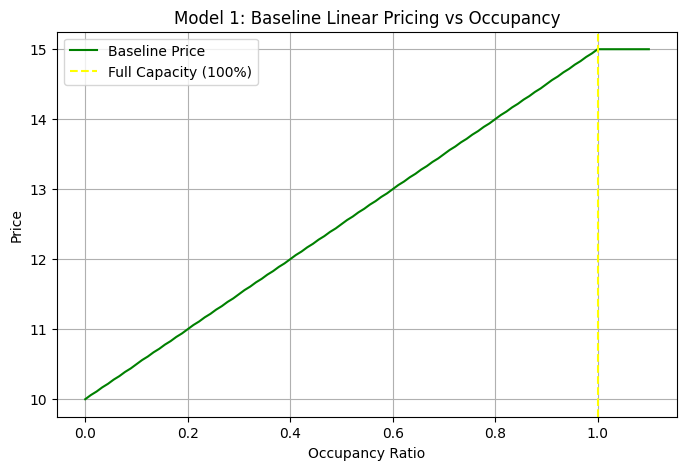

In [6]:
import numpy as np
import matplotlib.pyplot as plt
occupancies = np.linspace(0, 1.1, 100)

prices = [BaselineModelPrice(o, capacity=1) for o in occupancies]

plt.figure(figsize=(8, 5))
plt.plot(occupancies, prices, label='Baseline Price', color='green')
plt.axvline(1.0, linestyle='--', color='yellow', label='Full Capacity (100%)')
plt.xlabel('Occupancy Ratio')
plt.ylabel('Price')
plt.title('Model 1: Baseline Linear Pricing vs Occupancy')
plt.legend()
plt.grid(True)
plt.show()

Model 2: *Demand-Based Price Function*

In [8]:
def get_vehicle_weight(vehicle_type):
    wts = {'car': 1.0, 'bike': 0.6, 'truck': 1.7}
    return wts.get(str(vehicle_type).lower(), 1.0)

def get_traffic_weight(traffic_level):

    wts = {'low': 1.0, 'average': 0.7, 'high': 0.5}
    return wts.get(str(traffic_level).lower(), 1.0)

def nonlinear_demand_score(row):
    ratio = row['occupancy'] / row['capacity']
    occ_component = 1 / (1 + np.exp(-10 * (ratio - 0.6)))
    queue_component = 1.05 ** min(row['queuelength'], 10)
    traffic_component = get_traffic_weight(row['trafficconditionnearby'])
    vehicle_component = get_vehicle_weight(row['vehicletype'])
    special_day_component = 1.2 if row['isspecialday'] else 1.0
    demand_score = occ_component * queue_component * traffic_component * vehicle_component * special_day_component
    return min(demand_score, 5.0)


In [9]:
def model2_price_bounded(row, base_price=10):
    demand_score = nonlinear_demand_score(row)
    bounded_factor = 0.8 + (demand_score / 5) * 1.2
    return round(base_price * bounded_factor, 2)


In [10]:
data['model2_price'] = data.apply(model2_price_bounded, axis=1)


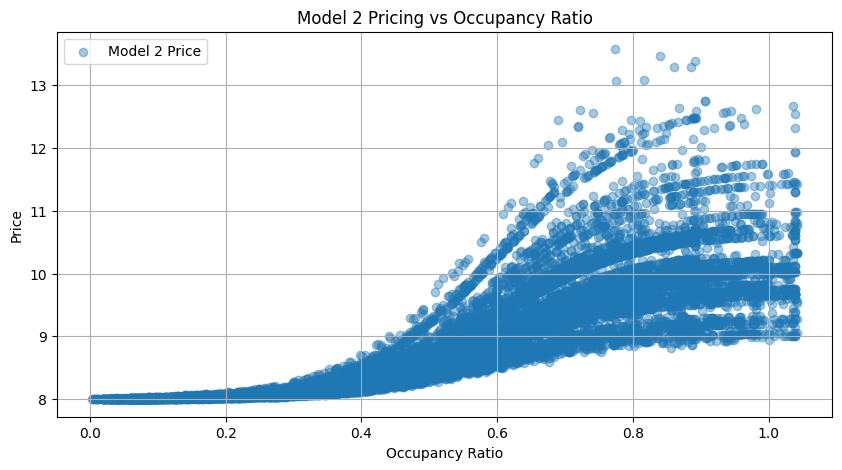

In [15]:
data['model2_price'] = data.apply(model2_price_bounded, axis=1)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(data['occupancy'] / data['capacity'], data['model2_price'],alpha=0.4, label='Model 2 Price')
plt.xlabel("Occupancy Ratio")
plt.ylabel("Price")
plt.title("Model 2 Pricing vs Occupancy Ratio")
plt.grid(True)
plt.legend()
plt.show()


In [16]:
data['lot_id'] = data.groupby(['latitude', 'longitude']).ngroup()


In [17]:

data['model2_price'] = 10 + 5 * (data['occupancy'] / data['capacity'])


cleaned_path = "dataset.csv"
data[['timestamp', 'lot_id', 'occupancy', 'capacity', 'model2_price']].to_csv(cleaned_path, index=False)



Model 3 : *Competitive Pricing Model*

In [20]:

from math import radians, cos, sin, asin, sqrt
import json


def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    return 2 * R * asin(sqrt(a))


locations = data[['lot_id', 'latitude', 'longitude']].drop_duplicates()
nearby_map = {}

for i, row in locations.iterrows():
    lot_i = row['lot_id']
    nearby = []
    for j, r2 in locations.iterrows():
        if row['lot_id'] == r2['lot_id']:
            continue
        d = haversine(row['latitude'], row['longitude'], r2['latitude'], r2['longitude'])
        if d <= 2:
            nearby.append(r2['lot_id'])
    nearby_map[lot_i] = nearby


with open("competitve_price.json", "w") as f:
    json.dump(nearby_map, f)

In [19]:

def model3_competitor_logic(lot_id, timestamp, occupancy, capacity, model2_price):
    ratio = occupancy / capacity
    nearby_ids = nearby_map.get(str(lot_id)) or nearby_map.get(int(lot_id)) or []
    competitors = data[
        (data['lot_id'].isin(nearby_ids)) &
        (data['timestamp'] == timestamp)
    ]

    if competitors.empty:
        return model2_price

    avg_price = competitors['model2_price'].mean()
    cheaper_exists = (competitors['model2_price'] < model2_price).any()

    if ratio >= 1 and cheaper_exists:
        return round(model2_price * 0.95, 2)
    elif ratio < 1 and avg_price > model2_price:
        return round(model2_price * 1.05, 2)
    else:
        return model2_price

In [21]:

import pathway as pw

class PricingStream:
    def run(self, input_stream: pw.Table) -> pw.Table:
        table = input_stream.select(
            timestamp=input_stream.timestamp,
            lot_id=input_stream.lot_id,
            occupancy=input_stream.occupancy,
            capacity=input_stream.capacity,
            model2_price=input_stream.model2_price
        )

        def price_logic(row):
            ratio = row.occupancy / row.capacity
            if ratio >= 1:
                return round(row.model2_price * 0.95, 2)
            elif ratio < 1:
                return round(row.model2_price * 1.05, 2)
            return row.model2_price

        table += table.select(
            model3_price=pw.apply(price_logic, table)
        )

        return table.select(
            timestamp=table.timestamp,
            lot_id=table.lot_id,
            model3_price=table.model3_price
        )
        input_table = pw.io.csv.read(
    "dataset.csv",
    schema=pw.Schema(
        timestamp=str,
        lot_id=int,
        occupancy=float,
        capacity=float,
        model2_price=float
    ),
    mode="streaming",
    autocommit_duration_ms=1000
).with_timestamp_from_isoformat("timestamp")



In [22]:
import pathway as pw


class ParkingSchema(pw.Schema):
    timestamp: str
    lot_id: int
    occupancy: float
    capacity: float
    model2_price: float

input_table = pw.io.csv.read(
    "dataset.csv",
    schema=ParkingSchema,
    mode="streaming",
    autocommit_duration_ms=10000
)

data = input_table.with_columns(t = pw.this.timestamp)

# Define the pricing logic
def model3_logic(occupancy, capacity, model2_price):
    ratio = occupancy / capacity
    if ratio >= 1:
        return round(model2_price * 0.95, 2)
    elif ratio < 1:
        return round(model2_price * 1.05, 2)
    return model2_price

output = data.with_columns(
    model3_price = pw.apply(
        model3_competitor_logic,
        data.lot_id, data.timestamp, data.occupancy, data.capacity, data.model2_price
    )
)



pw.io.csv.write(
    table=output.select(
        timestamp = pw.this.timestamp,
        lot_id = pw.this.lot_id,
        model3_price = pw.this.model3_price
    ),
    filename="model3_price.csv"
)



pw.run() #In order to get bokeh plot we would need to stop this cell manually after running it atleast for a minute.


Output()

/usr/local/lib/python3.11/dist-packages/beartype/_util/hint/pep/utilpeptest.py:311: BeartypeDecorHintPep585DeprecationWarning: PEP 484 type hint typing.Iterable[pathway.internals.expression.ColumnReference] deprecated by PEP 585. This hint is scheduled for removal in the first Python version released after October 5th, 2025. To resolve this, import this hint from "beartype.typing" rather than "typing". For further commentary and alternatives, see also:
    https://beartype.readthedocs.io/en/latest/api_roar/#pep-585-deprecations
  warn(


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



KeyboardInterrupt: 

In [23]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.palettes import Category10
import pandas as pd

output_notebook()

data_prices = pd.read_csv("model3_price.csv")
data_prices['timestamp'] = pd.to_datetime(data_prices['timestamp'])

p = figure(x_axis_type='datetime', title='Model 3 Price Over Time per Lot',
           width=800, height=400)

p.xaxis.axis_label = 'Timestamp'
p.yaxis.axis_label = 'Model 3 Price (₹)'

palette = Category10[10]
for i, lot_id in enumerate(data_prices['lot_id'].unique()):
    data_lot = data_prices[data_prices['lot_id'] == lot_id]
    source = ColumnDataSource(data_lot)
    color = palette[i % len(palette)]
    p.line(x='timestamp', y='model3_price', source=source, legend_label=f"Lot {lot_id}", line_width=2, color=color)

p.legend.title = 'Parking Lots'
p.legend.location = 'top_left'

show(p)


In [28]:
from bokeh.transform import dodge
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.layouts import column


data_merged = pd.merge(data_prices, data[['timestamp', 'lot_id', 'occupancy']], on=['timestamp', 'lot_id'])
data_merged['revenue'] = data_merged['model3_price'] * data_merged['occupancy']


avg_revenue = data_merged.groupby('lot_id')['revenue'].mean().reset_index()
source = ColumnDataSource(avg_revenue)


p_rev = figure(x_range=[str(lid) for lid in avg_revenue['lot_id']],
               title="Average Revenue per Lot",
               x_axis_label="Lot ID", y_axis_label="Average Revenue",
               height=400, width=800)

p_rev.vbar(x='lot_id', top='revenue', width=0.7, source=source, color="#2b66e6")
p_rev.xaxis.major_label_orientation = 1

show(p_rev)


In [29]:
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource

plots = []


for lot_id in sorted(data_prices['lot_id'].unique()):
    data_lot = data_prices[data_prices['lot_id'] == lot_id]
    source = ColumnDataSource(data_lot)
    p = figure(x_axis_type='datetime', title=f"Lot {lot_id}", width=400, height=200)
    p.line(x='timestamp', y='model3_price', source=source, line_width=2)
    p.xaxis.axis_label = 'Timestamp'
    p.yaxis.axis_label = 'Price'
    plots.append(p)

grid = gridplot([plots[i:i+2] for i in range(0, len(plots), 2)])
show(grid)
